In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf

pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_rows", None)
plt.style.use("seaborn")

C:\Users\David Lau\AppData\Local\Temp\ipykernel_18308\2914271944.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [153]:
np.random.seed(100)

# 0. Data Processing

## 0a. Download the data

In [215]:
datas_US = pd.read_csv('raw_data_US.csv')
datas_CN = pd.read_csv('raw_data_CN.csv')

In [216]:
print(datas_US.shape)
print(datas_CN.shape)

(500, 20)
(200, 20)


## 0b. Functions for processing the data 

In [217]:
log = True
log_financials = ['revenue', 'debt', 'cash', 
                  'asset', 'equity', 'freeCashFlow',
                  'operatingCashFlow', 'marketCap']

In [218]:
def data_processing(datas):
    data_removed_column = datas.drop(['ticker', 'shortName', 
                                      'eps', 
                                      'dividendYield', 
                                      'earningGrowth'
                                     ], axis=1)

    datas_dropped_na = data_removed_column.dropna()
    if log:
        for i in log_financials:
            datas_dropped_na[i] = np.log(datas_dropped_na[i])
        datas_dropped_na = datas_dropped_na.fillna(0)
    x = datas_dropped_na.drop(['marketCap'], axis=1)
    y = datas_dropped_na['marketCap']
    x_array = np.array(x)
    y_array = np.array(y).reshape(-1, 1)
    return x.index, x.columns.values, x_array, y_array

In [219]:
def scaling(x, y, scaler_x, scaler_y):
    return scaler_x.transform(x), scaler_y.transform(y)

## 0c. Process the US data for training 

In [220]:
datas_index, x_column, x_array, y_array = data_processing(datas_US)

C:\Users\David Lau\AppData\Local\Temp\ipykernel_18308\318133294.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_dropped_na[i] = np.log(datas_dropped_na[i])
C:\Users\David Lau\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [221]:
scaler_x = StandardScaler().fit(x_array)
scaler_y = StandardScaler().fit(y_array)

In [222]:
x_scaled, y_scaled = scaling(x_array, y_array, scaler_x, scaler_y)

In [223]:
shuffled_indices = np.arange(x_scaled.shape[0])
np.random.shuffle(shuffled_indices)

x_shuffled = x_scaled[shuffled_indices]
y_shuffled = y_scaled[shuffled_indices]

samples_count = x_shuffled.shape[0]
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.2 * samples_count)
test_samples_count = samples_count - train_samples_count - validation_samples_count

train_x = x_shuffled[:train_samples_count]
train_y = y_shuffled[:train_samples_count]

validation_x = x_shuffled[train_samples_count:train_samples_count+validation_samples_count]
validation_y = y_shuffled[train_samples_count:train_samples_count+validation_samples_count]

test_x = x_shuffled[train_samples_count+validation_samples_count:]
test_y = y_shuffled[train_samples_count+validation_samples_count:]

In [224]:
print('size of training set:', train_samples_count)
print('size of validation set:', validation_samples_count)
print('size of test set:', test_samples_count)

size of training set: 354
size of validation set: 88
size of test set: 1


In [225]:
#saving the data for the NN model
np.savez('data_train', inputs=train_x, targets=train_y, allow_pickle=True, dtype=float)
np.savez('data_validation', inputs=validation_x, targets=validation_y, allow_pickle=True, dtype=float)
np.savez('data_test', inputs=test_x, targets=test_y, allow_pickle=True, dtype=float)

## 0d. Process the China data 

In [226]:
x_scaled_CN, y_scaled_CN = scaling(x_array_CN, y_array_CN, scaler_x, scaler_y)

In [227]:
datas_index_CN, datas_column_CN, x_array_CN, y_array_CN = data_processing(datas_CN)

C:\Users\David Lau\AppData\Local\Temp\ipykernel_18308\318133294.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_dropped_na[i] = np.log(datas_dropped_na[i])
C:\Users\David Lau\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [228]:
#saving the China data as test set for the NN model
np.savez('CN_data_test', inputs=x_scaled_CN, targets=y_scaled_CN, allow_pickle=True, dtype=float)

# 1. Fitting the US data with Linear Regression

In [229]:
reg = LinearRegression()
reg.fit(train_x, train_y)

LinearRegression()

## 1a. How the model fits the US data

In [230]:
LR_train_score = r2_score(train_y, reg.predict(train_x))
LR_validation_score = r2_score(validation_y, reg.predict(validation_x))

print('train score: {:.2f}'.format(LR_train_score))
print('validation score: {:.2f}'.format(LR_validation_score))

train score: 0.69
validation score: 0.58


## 1b. How each parameter correlates with the market cap

In [231]:
p_values = f_regression(x_scaled, y_scaled)[1]
reg_summary = pd.DataFrame(data = x_column, columns=['Features'])
reg_summary['Coefficients'] = reg.coef_.reshape(-1, 1)
reg_summary['p-values'] = p_values.round(3)
reg_summary.sort_values(by="p-values", ascending=True)

C:\Users\David Lau\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Features,Coefficients,p-values
0,revenue,0.3060,0.0000
5,debt,-0.0103,0.0000
6,cash,0.2822,0.0000
7,asset,0.4083,0.0000
9,returnOnAsset,0.1777,0.0000
12,freeCashFlow,0.0986,0.0000
13,operatingCashFlow,0.0009,0.0000
4,netMargin,0.0108,0.0010
3,operatingMargin,-0.1611,0.0020
2,grossMargin,0.4088,0.0110


## 1c. Fitting the China data with the model, then evaluate the results 

In [232]:
def show_result(y_results_CN_inverse, y_array_CN, datas_CN):
    
    if log:
        y_results_CN_inverse = np.exp(y_results_CN_inverse)
        y_array_CN = np.exp(y_array_CN)
    
    discount = y_array_CN / y_results_CN_inverse - 1
    
    results = pd.DataFrame(discount, index=datas_index_CN)
    results.columns = ["discount"]
    
    results["market_cap_est"] = y_results_CN_inverse
    
    datas_CN_results = pd.concat([datas_CN, results], axis=1)
    datas_CN_results_dropped_na = datas_CN_results.dropna(subset=['discount'])
    full_summary = datas_CN_results_dropped_na
    summary = datas_CN_results_dropped_na[["shortName", "marketCap", "market_cap_est", "discount"]].sort_values(by=['discount'])
    
    return full_summary, summary

In [233]:
y_results_CN_inverse = scaler_y.inverse_transform(reg.predict(x_scaled_CN))
full_summary, summary = show_result(y_results_CN_inverse, y_array_CN, datas_CN)
summary

,shortName,marketCap,market_cap_est,discount
168,COUNTRY GARDEN,3824737822.7331,100821976669.4137,-0.9621
182,DAQO New Energy Corp.,2510375680.0000,51286994128.6480,-0.9511
55,CITIC,27938576412.7714,435973268877.8431,-0.9359
158,FOSUN INTL,5129322454.1507,73231439654.4793,-0.9300
192,JinkoSolar Holding Company Limi,1542989440.0000,16861164962.3886,-0.9085
176,DONGFENG GROUP,3320487004.8531,31990736177.3705,-0.8962
178,Weibo Corporation,2848740352.0000,27145990828.1910,-0.8951
191,CHINA LESSO,1628473346.6156,14327663296.4485,-0.8863
100,CHINA RAILWAY CONSTRUCTION CORP,15042785927.9230,131956543943.9389,-0.8860
194,Hello Group Inc.,1358887040.0000,11375038565.5723,-0.8805


In [234]:
summary_remove_outlier = summary[summary["discount"]<10]

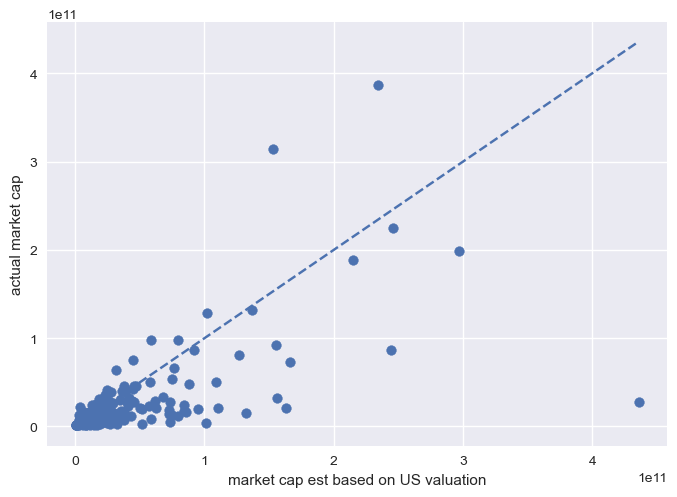

In [235]:
plt.scatter(summary_remove_outlier["market_cap_est"], summary_remove_outlier["marketCap"])
plt.xlabel('market cap est based on US valuation')
plt.ylabel('actual market cap')

x = [0, summary_remove_outlier["market_cap_est"].max()]
plt.plot(x, x, '--')

plt.show()

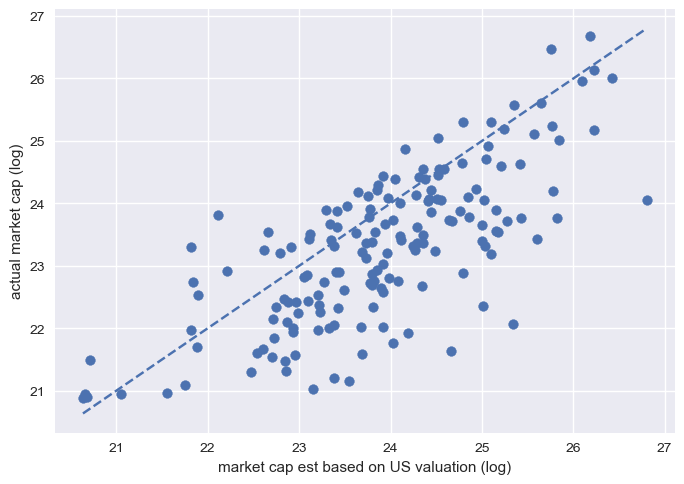

In [236]:
plt.scatter(np.log(summary_remove_outlier["market_cap_est"]), np.log(summary_remove_outlier["marketCap"]))
plt.xlabel('market cap est based on US valuation (log)')
plt.ylabel('actual market cap (log)')

x = [np.log(summary_remove_outlier["market_cap_est"]).min(), 
     np.log(summary_remove_outlier["market_cap_est"]).max()]
plt.plot(x, x, '--')

plt.show()

# 2. Results from nerual network

## 2a. Loading the result from the NN model 

In [237]:
NN_train_y_predict = np.loadtxt("NN_train_y_predict.csv", delimiter=",", dtype=float)
NN_validation_y_predict = np.loadtxt("NN_validation_y_predict.csv", delimiter=",", dtype=float)

## 2b. Evaluating how the NN model fits the US data 

In [238]:
NN_train_score = r2_score(train_y, NN_train_y_predict)
NN_validation_score = r2_score(validation_y, NN_validation_y_predict)

print('NN train score: {:.2f}'.format(NN_train_score))
print('NN validation score: {:.2f}'.format(NN_validation_score))

NN train score: 0.77
NN validation score: 0.65


## 2c. Fitting the China data into the model 

In [239]:
CN_test_y_predict = np.loadtxt("NN_CN_test_y_predict.csv", delimiter=",", dtype=float)
y_results_CN_inverse = scaler_y.inverse_transform(np.array(CN_test_y_predict).reshape(-11, 1))
full_summary, summary = show_result(y_results_CN_inverse, y_array_CN, datas_CN)
summary

,shortName,marketCap,market_cap_est,discount
168,COUNTRY GARDEN,3824737822.7331,89170577434.0060,-0.9571
55,CITIC,27938576412.7714,405332247353.6650,-0.9311
182,DAQO New Energy Corp.,2510375680.0000,33044436555.0089,-0.9240
194,Hello Group Inc.,1358887040.0000,16747906586.4510,-0.9189
192,JinkoSolar Holding Company Limi,1542989440.0000,18961714954.7373,-0.9186
76,COSCO SHIPPING HOLDINGS,20920560576.6162,247937231822.4691,-0.9156
191,CHINA LESSO,1628473346.6156,19249489454.1085,-0.9154
158,FOSUN INTL,5129322454.1507,58288088367.0280,-0.9120
184,JOYY Inc.,2380469760.0000,23790998439.2808,-0.8999
176,DONGFENG GROUP,3320487004.8531,30332526535.7331,-0.8905


In [240]:
summary_remove_outlier = summary[summary["discount"]<10]
summary_remove_outlier

,shortName,marketCap,market_cap_est,discount
168,COUNTRY GARDEN,3824737822.7331,89170577434.0060,-0.9571
55,CITIC,27938576412.7714,405332247353.6650,-0.9311
182,DAQO New Energy Corp.,2510375680.0000,33044436555.0089,-0.9240
194,Hello Group Inc.,1358887040.0000,16747906586.4510,-0.9189
192,JinkoSolar Holding Company Limi,1542989440.0000,18961714954.7373,-0.9186
76,COSCO SHIPPING HOLDINGS,20920560576.6162,247937231822.4691,-0.9156
191,CHINA LESSO,1628473346.6156,19249489454.1085,-0.9154
158,FOSUN INTL,5129322454.1507,58288088367.0280,-0.9120
184,JOYY Inc.,2380469760.0000,23790998439.2808,-0.8999
176,DONGFENG GROUP,3320487004.8531,30332526535.7331,-0.8905


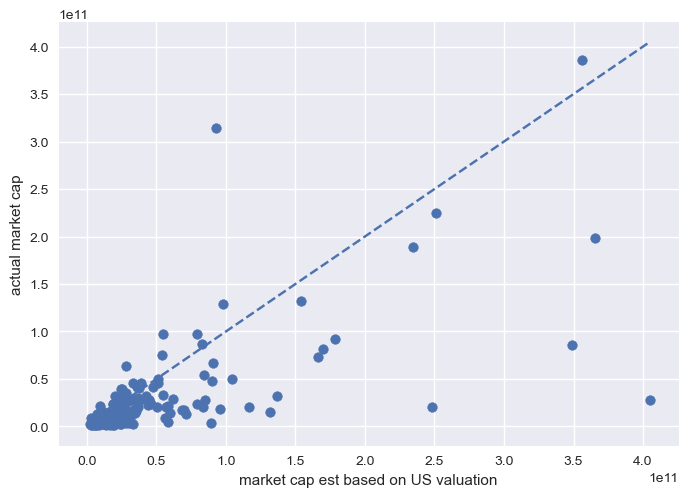

In [241]:
plt.scatter(summary_remove_outlier["market_cap_est"], summary_remove_outlier["marketCap"])
plt.xlabel('market cap est based on US valuation')
plt.ylabel('actual market cap')

x = [1, summary_remove_outlier["market_cap_est"].max()]
plt.plot(x, x, '--')

plt.show()

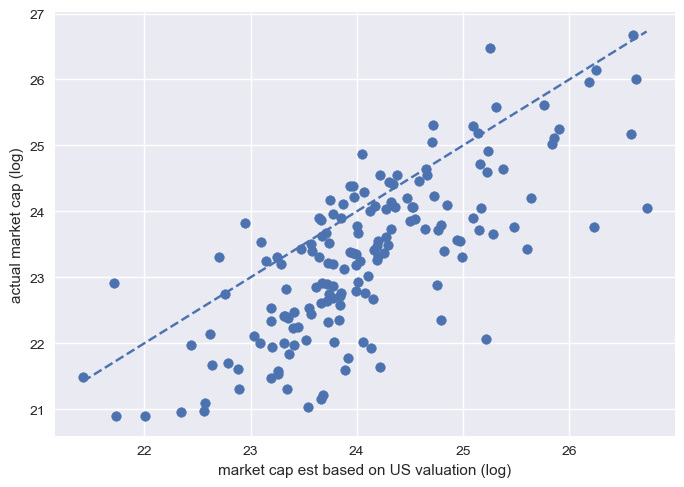

In [242]:
plt.scatter(np.log(summary_remove_outlier["market_cap_est"]), np.log(summary_remove_outlier["marketCap"]))
plt.xlabel('market cap est based on US valuation (log)')
plt.ylabel('actual market cap (log)')

x = [np.log(summary_remove_outlier["market_cap_est"]).min(), np.log(summary_remove_outlier["market_cap_est"]).max()]
plt.plot(x, x, '--')

plt.show()

## 2d. Additional analysis of the results 

In [243]:
full_summary_remove_outlier = full_summary[full_summary["discount"]<10]
full_summary_remove_outlier.sort_values(by=['discount'])

,ticker,shortName,revenue,revenueGrowth,earningGrowth,grossMargin,operatingMargin,netMargin,eps,debt,...,equity,returnOnAsset,returnOnEquity,debtEquityRatio,freeCashFlow,operatingCashFlow,marketCap,dividendYield,discount,market_cap_est
168,2007.HK,COUNTRY GARDEN,59198211829.4360,-0.1772,-1.2258,0.0764,0.0275,-0.0141,-0.0358,37375240715.2682,...,28008665749.6561,-0.0035,-0.0297,1.3344,4632187070.1513,4899724896.8363,3824737822.7331,0.0314,-0.9571,89170577434.0060
55,0267.HK,CITIC,135106877579.0922,0.0853,0.0749,0.3642,0.1363,0.0768,0.3563,299608665749.6561,...,101410041265.4746,0.0064,0.1024,2.9544,23444704264.0990,26687620357.6341,27938576412.7714,0.0940,-0.9311,405332247353.6650
182,DQ,DAQO New Energy Corp.,4608349000.0000,1.7450,1.4595,0.7395,0.6598,0.4036,23.3500,20687000.0000,...,4847535000.0000,0.2450,0.3837,0.0043,2466927000.0000,2466927000.0000,2510375680.0000,0.0000,-0.9240,33044436555.0089
194,MOMO,Hello Group Inc.,1747478954.6080,-0.1284,-1.5094,0.4158,0.1281,0.1168,1.0041,380715405.7772,...,1503526547.4553,0.0938,0.1358,0.2532,157695460.7978,168760797.7992,1358887040.0000,0.0851,-0.9189,16747906586.4510
192,JKS,JinkoSolar Holding Company Limi,11489527922.9711,1.0459,-0.0775,0.1478,0.0230,0.0080,1.7056,6572231499.3122,...,2253377854.1953,0.0061,0.0406,2.9166,-2494140440.1651,-797907015.1307,1542989440.0000,0.0000,-0.9186,18961714954.7373
76,601919.SS,COSCO SHIPPING HOLDINGS,53790714801.5378,0.1719,0.2273,0.4426,0.4091,0.2803,0.9312,12828633141.3714,...,27562967355.0028,0.2141,0.5469,0.4654,25626868586.8556,27069986946.4113,20920560576.6162,0.3150,-0.9156,247937231822.4691
191,2128.HK,CHINA LESSO,4232078541.9532,-0.0403,-0.1731,0.2679,0.1731,0.0818,0.1128,2835500412.6547,...,2997833975.2407,0.0427,0.1155,0.9458,229810316.3686,628980742.7785,1628473346.6156,0.0548,-0.9154,19249489454.1085
158,0656.HK,FOSUN INTL,24125642228.3356,0.0874,-0.9466,0.3272,0.0260,0.0031,0.0083,33890871251.7194,...,16715388720.7703,0.0007,0.0044,2.0275,-1345502338.3769,242601650.6190,5129322454.1507,0.0942,-0.9120,58288088367.0280
184,YY,JOYY Inc.,2411516000.0000,-0.0792,-2.6053,0.3534,0.0272,0.0534,1.6000,907582000.0000,...,5178217000.0000,0.0142,0.0249,0.1753,247275000.0000,316494000.0000,2380469760.0000,0.0613,-0.8999,23790998439.2808
176,0489.HK,DONGFENG GROUP,12745942228.3356,-0.1800,-0.0985,0.0953,-0.0175,0.1108,0.1639,7517744154.0578,...,21437689133.4250,0.0311,0.0659,0.3507,-242365887.2077,902613480.0550,3320487004.8531,0.1071,-0.8905,30332526535.7331


In [244]:
summary_copy = full_summary_remove_outlier.sort_values(by='discount')

In [245]:
total = summary_copy.count()[0]
number_discount = summary_copy[summary_copy['discount']<0].count()[0]
number_premium = summary_copy[summary_copy['discount']>0].count()[0]
print('discount: {} / {:.2f}'.format(number_discount, number_discount / total))
print('premium: {} / {:.2f}'.format(number_premium, number_premium / total))

discount: 134 / 0.82
premium: 29 / 0.18


In [246]:
print('average discount: {:.2f}'.format(np.average(summary_copy['discount'])))

average discount: -0.37


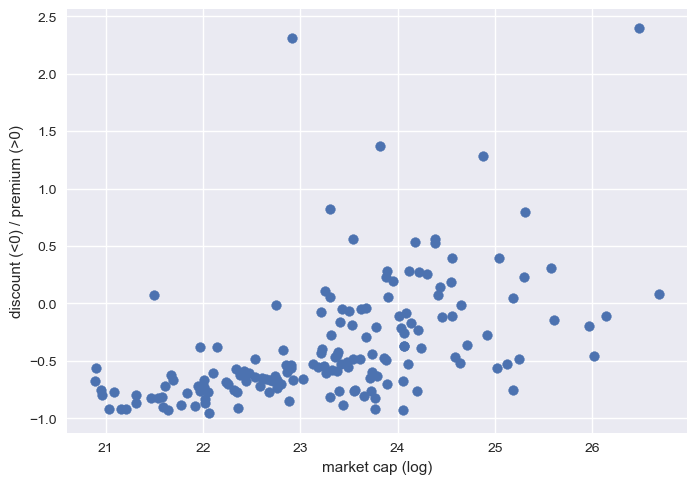

In [247]:
#Correlation between size and discount / premium level
plt.scatter(np.log(summary_copy["marketCap"]), summary_copy['discount'])
plt.xlabel('market cap (log)')
plt.ylabel('discount (<0) / premium (>0)')
plt.show()

In [248]:
discount_summary = summary_copy[summary_copy['discount']<0].describe() #trading at discount
discount_summary

,revenue,revenueGrowth,earningGrowth,grossMargin,operatingMargin,netMargin,eps,debt,cash,asset,equity,returnOnAsset,returnOnEquity,debtEquityRatio,freeCashFlow,operatingCashFlow,marketCap,dividendYield,discount,market_cap_est
count,134.0000,134.0000,134.0000,134.0000,134.0000,134.0000,131.0000,134.0000,134.0000,134.0000,134.0000,134.0000,134.0000,134.0000,134.0000,134.0000,134.0000,124.0000,134.0000,134.0000
mean,28523385944.0902,0.2043,-0.8479,0.3545,0.0728,0.0305,0.4333,10422124809.9409,7701551362.4074,51999551742.6550,14971493318.9415,0.0298,0.0555,0.6645,1689250905.9556,3129976624.7818,21016434739.4613,0.0390,-0.5648,49342524741.9812
std,65544530569.2629,0.6216,7.1610,0.2638,0.2901,0.2965,2.2212,29253982341.4767,11924509768.6584,153905829755.0649,28986746320.2516,0.0955,0.2306,0.8169,6404544130.9881,7592511467.8096,34159205157.8280,0.0528,0.2460,67705666995.4070
min,115220907.8404,-0.7678,-78.6189,-0.3849,-1.8804,-2.0614,-4.6000,1066757.6657,21285000.0000,245259000.0000,-432624071.5268,-0.3633,-1.4130,-0.0091,-5154745529.5736,-1314210316.3686,1182440064.0000,0.0000,-0.9571,2741181058.4856
25%,1721033523.2311,-0.0409,-0.5055,0.1547,0.0276,0.0212,0.0220,294868947.7304,1288559739.3043,4435208892.3030,2132766699.6620,0.0113,0.0348,0.1434,-127125475.7256,115260919.9175,4699340194.6564,0.0038,-0.7587,16533430556.6926
50%,6602799931.2242,0.0725,0.0173,0.2728,0.0732,0.0582,0.1252,2573254676.7538,2876523463.5598,12427627558.9512,5462848761.9670,0.0336,0.0854,0.4010,265649948.4182,679755294.0358,12004890339.4773,0.0159,-0.6046,26256270416.9089
75%,24117530695.5234,0.2185,0.2286,0.4947,0.1773,0.1295,0.3581,8883889980.7428,7764875343.8790,40068291800.4632,13820304177.7211,0.0690,0.1517,0.8735,1026826100.4127,2695841700.1393,20985416698.9433,0.0513,-0.4368,50757006554.3635
max,456419257221.4581,4.2782,10.6047,0.9572,0.8342,0.6815,23.3500,299608665749.6561,72141678129.2985,1622310729023.3838,188353094910.5915,0.3405,0.5469,5.1979,54163411279.2297,54163411279.2297,224449036288.0000,0.3150,-0.0089,405332247353.6650


In [249]:
premium_summary = summary_copy[summary_copy['discount']>0].describe() #trading at premium
premium_summary

,revenue,revenueGrowth,earningGrowth,grossMargin,operatingMargin,netMargin,eps,debt,cash,asset,equity,returnOnAsset,returnOnEquity,debtEquityRatio,freeCashFlow,operatingCashFlow,marketCap,dividendYield,discount,market_cap_est
count,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,29.0000,28.0000,29.0000,29.0000
mean,13626703526.1303,0.1711,0.3963,0.2118,-0.0246,-0.0714,-0.1470,6877850243.5513,6077623775.3851,27442583278.5389,11605872867.5620,0.0382,-0.6228,4.3466,973171851.9814,2490155471.2831,62633799300.5811,0.0130,0.5127,43973917036.2990
std,18749271788.3760,0.4092,1.8036,0.4873,0.5258,0.5336,3.9493,11587927527.5168,8583655816.4985,41571520852.2686,18461112315.4445,0.1331,3.2553,18.0648,3014581290.1159,5261442760.8611,85680362374.8117,0.0161,0.6111,65393123518.5522
min,306870426.4099,-0.3330,-5.2888,-0.9741,-1.5922,-1.5808,-19.3700,32534317.6066,219708253.0949,3655962259.0495,160162173.3150,-0.3141,-17.3886,0.0022,-3356265612.1045,-2305647455.2957,2158004409.7063,0.0000,0.0451,2012923124.2731
25%,3145005914.7180,-0.0644,-0.1889,0.1491,-0.0807,-0.1314,-0.1499,608206464.9243,1501555845.9422,6429881266.7125,3631042163.0550,-0.0296,-0.0753,0.1259,-277976891.3343,-16088219.8611,23391596808.8033,0.0018,0.1448,18538321137.5891
50%,6229273177.4415,0.1193,0.1955,0.2839,0.1252,0.0935,0.1289,1686984594.2228,2611945386.5034,11826000000.0000,5449889018.1871,0.0651,0.1149,0.2732,318076156.6836,762265887.2077,35649746815.8365,0.0058,0.2844,25515579398.3979
75%,12954954883.0812,0.2279,0.7291,0.5046,0.2540,0.2556,0.7854,7990044704.2641,7772958872.0770,34988281292.3315,15272255708.3906,0.1193,0.2180,0.5887,1057698486.9326,1670034095.7359,63701435602.5543,0.0158,0.5635,38785557843.6842
max,76279504814.3054,1.5207,5.2597,0.9200,0.6777,0.4917,6.8680,49400412654.7455,39818156808.8033,217074415405.7772,99228473177.4415,0.2466,0.3527,97.5571,13100550206.3274,20095048143.0536,386215641088.0000,0.0575,2.3935,355907678862.1934


In [250]:
comparison = pd.concat([pd.DataFrame(discount_summary.loc['mean']), pd.DataFrame(premium_summary.loc['mean'])], axis=1)
new_index = ['discount', 'marketCap', 'revenue',
            'revenueGrowth', 'earningGrowth',
            'grossMargin', 'operatingMargin', 'netMargin']
comparison_copy = comparison.loc[new_index]
comparison_copy_div = comparison_copy
comparison_copy_div.loc['marketCap'] = comparison_copy.loc['marketCap'] / 1000000
comparison_copy_div.loc['revenue'] = comparison_copy.loc['revenue'] / 1000000
comparison_copy_div.columns = ['Companies valued at discount',
                              'Companies valued at premium']
comparison_copy_div

,Companies valued at discount,Companies valued at premium
discount,-0.5648,0.5127
marketCap,21016.4347,62633.7993
revenue,28523.3859,13626.7035
revenueGrowth,0.2043,0.1711
earningGrowth,-0.8479,0.3963
grossMargin,0.3545,0.2118
operatingMargin,0.0728,-0.0246
netMargin,0.0305,-0.0714


In [251]:
naas = full_summary.sort_values(by=['discount'], ascending=False).iloc[0]
naas

ticker                               NAAS
shortName            Naas Technology Inc.
revenue                     12766712.5172
revenueGrowth                      4.2219
earningGrowth                     21.3430
grossMargin                        0.0664
operatingMargin                  -26.5887
netMargin                        -60.7383
eps                               -4.0165
debt                        71435350.7565
cash                        70612242.0908
asset                      152123108.6657
equity                      60367812.9298
returnOnAsset                     -5.0974
returnOnEquity                   -12.8451
debtEquityRatio                    1.1833
freeCashFlow               -82232187.0702
operatingCashFlow          -79875653.3700
marketCap                 1250024960.0000
dividendYield                     -0.0000
discount                        3290.2000
market_cap_est                379808.2680
Name: 196, dtype: object

In [252]:
print('market cap / revenue ratio:')
print('naas: {:.1f}x'.format(naas['marketCap'] / naas['revenue']))
print('average: {:.1f}x'.format(np.mean(full_summary['marketCap'] / full_summary['revenue'])))

market cap / revenue ratio:
naas: 97.9x
average: 4.6x


## Additional analysis: Comparing with the discount level in 2021 

In [253]:
datas_US_2021 = pd.read_csv('raw_data_US_2021.csv')
datas_CN_2021 = pd.read_csv('raw_data_CN_2021.csv')

In [254]:
print(datas_US_2021.shape)
print(datas_CN_2021.shape)

(500, 20)
(200, 20)


In [255]:
datas_index_2021, x_column_2021, x_array_2021, y_array_2021 = data_processing(datas_US_2021)

C:\Users\David Lau\AppData\Local\Temp\ipykernel_18308\318133294.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_dropped_na[i] = np.log(datas_dropped_na[i])
C:\Users\David Lau\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [256]:
scaler_x_2021 = StandardScaler().fit(x_array_2021)
scaler_y_2021 = StandardScaler().fit(y_array_2021)

In [257]:
x_scaled_2021, y_scaled_2021 = scaling(x_array_2021, y_array_2021, scaler_x_2021, scaler_y_2021)

In [258]:
shuffled_indices_2021 = np.arange(x_scaled_2021.shape[0])
np.random.shuffle(shuffled_indices_2021)

x_shuffled_2021 = x_scaled_2021[shuffled_indices_2021]
y_shuffled_2021 = y_scaled_2021[shuffled_indices_2021]

samples_count_2021 = x_shuffled_2021.shape[0]
train_samples_count_2021 = int(0.8 * samples_count_2021)
validation_samples_count_2021 = int(0.2 * samples_count_2021)
test_samples_count_2021 = samples_count_2021 - train_samples_count_2021 - validation_samples_count_2021

train_x_2021 = x_shuffled_2021[:train_samples_count_2021]
train_y_2021 = y_shuffled_2021[:train_samples_count_2021]

validation_x_2021 = x_shuffled_2021[train_samples_count_2021:train_samples_count_2021+validation_samples_count_2021]
validation_y_2021 = y_shuffled_2021[train_samples_count_2021:train_samples_count_2021+validation_samples_count_2021]

test_x_2021 = x_shuffled_2021[train_samples_count_2021+validation_samples_count_2021:]
test_y_2021 = y_shuffled_2021[train_samples_count_2021+validation_samples_count_2021:]

In [259]:
print('size of training set:', train_samples_count_2021)
print('size of validation set:', validation_samples_count_2021)
print('size of test set:', test_samples_count_2021)

size of training set: 348
size of validation set: 87
size of test set: 1


In [260]:
datas_index_CN_2021, datas_column_CN_2021, x_array_CN_2021, y_array_CN_2021 = data_processing(datas_CN_2021)

C:\Users\David Lau\AppData\Local\Temp\ipykernel_18308\318133294.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas_dropped_na[i] = np.log(datas_dropped_na[i])
C:\Users\David Lau\anaconda3\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [261]:
x_scaled_CN_2021, y_scaled_CN_2021 = scaling(x_array_CN_2021, y_array_CN_2021, scaler_x_2021, scaler_y_2021)

In [262]:
reg_2021 = LinearRegression()
reg_2021.fit(train_x_2021, train_y_2021)

LinearRegression()

In [263]:
LR_train_score_2021 = r2_score(train_y_2021, reg_2021.predict(train_x_2021))
LR_validation_score_2021 = r2_score(validation_y_2021, reg_2021.predict(validation_x_2021))

print('train score (2021): {:.2f}'.format(LR_train_score_2021))
print('validation score (2021): {:.2f}'.format(LR_validation_score_2021))

train score (2021): 0.69
validation score (2021): 0.49


In [264]:
scaler_y_2021.inverse_transform(reg_2021.predict(x_scaled_CN_2021)).shape

(148, 1)

In [265]:
y_array_CN_2021.shape

(148, 1)

In [267]:
y_results_CN_inverse_2021 = scaler_y_2021.inverse_transform(reg_2021.predict(x_scaled_CN_2021))

In [268]:
if log:
    y_results_CN_inverse_2021 = np.exp(y_results_CN_inverse_2021)
    y_array_CN_2021 = np.exp(y_array_CN_2021)

discount_2021 = y_array_CN_2021 / y_results_CN_inverse_2021 - 1

results_2021 = pd.DataFrame(discount_2021, index=datas_index_CN_2021)
results_2021.columns = ["discount"]

results_2021["market_cap_est"] = y_results_CN_inverse_2021

datas_CN_results_2021 = pd.concat([datas_CN_2021, results_2021], axis=1)
datas_CN_results_dropped_na_2021 = datas_CN_results_2021.dropna(subset=['discount'])
full_summary_2021 = datas_CN_results_dropped_na_2021
summary_2021 = datas_CN_results_dropped_na_2021[["shortName", "marketCap", "market_cap_est", "discount"]].sort_values(by=['discount'])

In [269]:
summary_2021

,shortName,marketCap,market_cap_est,discount
186,CHINA RAILWAY MATE,3067991083.7204,179165092943536694025519104.0000,-1.0000
36,Li Auto Inc.,28996578112.1196,1822930443170600.0000,-1.0000
126,New Oriental Education & Techno,3340658445.7268,48281647041.7695,-0.9308
55,CITIC,35356810780.9415,411059811393.9268,-0.9140
158,FOSUN INTL,10310226183.3771,90162676305.0750,-0.8856
194,Hello Group Inc.,2241161110.0562,19544150630.9060,-0.8853
103,CHINA MERCHANTS SH,12201535215.4802,102254871174.4839,-0.8807
100,CHINA RAILWAY CONSTRUCTION CORP,14869881328.1276,124542146080.4440,-0.8806
168,COUNTRY GARDEN,25215886920.4566,176252231808.4728,-0.8569
161,KINGSOFT,5202854242.1728,35875431764.0402,-0.8550


In [270]:
summary_remove_outlier_2021 = summary_2021[summary_2021["discount"]<10]
summary_remove_outlier_2021 = summary_remove_outlier_2021[summary_remove_outlier_2021["discount"]>-0.99]
summary_remove_outlier_2021

,shortName,marketCap,market_cap_est,discount
126,New Oriental Education & Techno,3340658445.7268,48281647041.7695,-0.9308
55,CITIC,35356810780.9415,411059811393.9268,-0.9140
158,FOSUN INTL,10310226183.3771,90162676305.0750,-0.8856
194,Hello Group Inc.,2241161110.0562,19544150630.9060,-0.8853
103,CHINA MERCHANTS SH,12201535215.4802,102254871174.4839,-0.8807
100,CHINA RAILWAY CONSTRUCTION CORP,14869881328.1276,124542146080.4440,-0.8806
168,COUNTRY GARDEN,25215886920.4566,176252231808.4728,-0.8569
161,KINGSOFT,5202854242.1728,35875431764.0402,-0.8550
133,SINOPHARM,8209023139.3598,56468263882.6912,-0.8546
171,Autohome Inc.,5243653162.1447,35410740029.6259,-0.8519


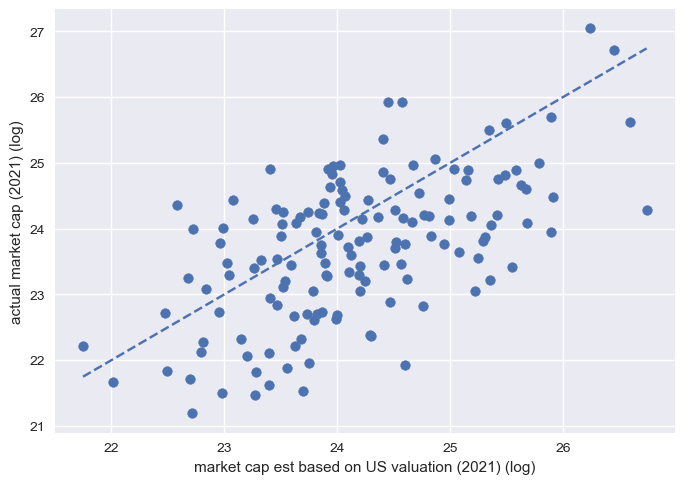

In [271]:
plt.scatter(np.log(summary_remove_outlier_2021["market_cap_est"]), np.log(summary_remove_outlier_2021["marketCap"]))
plt.xlabel('market cap est based on US valuation (2021) (log)')
plt.ylabel('actual market cap (2021) (log)')

x = [np.log(summary_remove_outlier_2021["market_cap_est"]).min(), np.log(summary_remove_outlier_2021["market_cap_est"]).max()]
plt.plot(x, x, '--')

plt.show()

In [274]:
summary_copy_2021 = summary_remove_outlier_2021.sort_values(by='discount')

In [276]:
total_2021 = summary_copy_2021.count()[0]
number_discount_2021 = summary_copy_2021[summary_copy_2021['discount']<0].count()[0]
number_premium_2021 = summary_copy_2021[summary_copy_2021['discount']>0].count()[0]
print('discount (2021): {} / {:.2f}'.format(number_discount_2021, number_discount_2021 / total_2021))
print('premium (2021): {} / {:.2f}'.format(number_premium_2021, number_premium_2021 / total_2021))

discount (2021): 95 / 0.66
premium (2021): 49 / 0.34


In [277]:
print('average discount: {:.2f}'.format(np.average(summary_copy_2021['discount'])))

average discount: -0.02
